## Homework #2 - CSE 572 Fall '23
### Tyler Fichiera

Below is some of the preprocessing code from the homework 1 solutions.

In [ ]:
import numpy as np
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.precision", 4)
sns.set()
seed = 0

train_path = 'news-train-1.csv'
test_path = 'news-test.csv'
dictionary_path = 'dictionary.txt'

train_df = pd.read_csv(train_path)
labels = train_df['Category'].unique().tolist()
test_df = pd.read_csv(test_path)
vocab = pd.read_csv(dictionary_path, header=None)[0].tolist()

# Print dataset information
print("Number of Train samples = ", train_df.shape[0])
print("Number of Test samples = ", test_df.shape[0])
print("Vocabulary size = ", len(vocab))
print("Number of instances for each label:")
display(train_df[['ArticleId', 'Category']].groupby(by='Category').agg('count'))

# Preprocessing functions
stemmer = PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def get_tokens(text):
    """
    Perform lowercase, punctuation and stopword removal, tokenization
    and stemming to get tokens from given text
    """
    lowers = text.lower()
    no_punctuation = lowers.translate(remove_punctuation_map)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [w for w in tokens if not w in stopwords.words("english")]
    stemmed = [stemmer.stem(item) for item in filtered]

    return stemmed

train_df['Processed_Text'] = train_df['Text'].apply(get_tokens)
X = train_df['Processed_Text'].apply(lambda x: ' '.join(x)).tolist()  # Convert to a list of strings
y = train_df['Category']


Number of Train samples =  1063
Number of Test samples =  735
Vocabulary size =  1000
Number of instances for each label:


,ArticleId
Category,
business,237
entertainment,193
politics,200
sport,246
tech,187



KeyboardInterrupt



Feature extraction methods below

In [3]:
# Method 1 CountVectorizer
count_vectorizer = CountVectorizer()
X_count_vectorizer = count_vectorizer.fit_transform(X)

In [4]:
# Method 2 TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [5]:
# Method 3 GloVe
import gensim.downloader as api
import seaborn as sns
glove_model = api.load("glove-wiki-gigaword-100")  # Load GloVe vectors

def text_to_glove(text, model):
    words = text.split()
    word_vectors = [model[word] for word in words if word in model]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

X_glove = np.array([text_to_glove(text, glove_model) for text in X])

In [13]:
# Method 4 BERT
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

def text_to_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

X_bert = np.array([text_to_bert_embeddings(text) for text in X])

In [18]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

model = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=500)

train_accuracies = []
val_accuracies = []
train_accuracies_std = []
val_accuracies_std = []

for X_data in [X_count_vectorizer, X_tfidf, X_glove, X_bert]:
    X_train, X_val, y_train, y_val = train_test_split(X_data, y, test_size=0.2, random_state=seed)
    
    # Training accuracy
    train_scores = cross_val_score(model, X_train, y_train, cv=5)
    train_accuracies.append(train_scores.mean())
    train_accuracies_std.append(train_scores.std())
    
    # Validation accuracy
    val_scores = cross_val_score(model, X_val, y_val, cv=5)
    val_accuracies.append(val_scores.mean())
    val_accuracies_std.append(val_scores.std())

# Results table
results = {
    "Feature Method": ["CountVectorizer", "TF-IDF", "GloVe", "BERT"],
    "Training Accuracy": train_accuracies,
    "Training Accuracy Std Dev": train_accuracies_std,
    "Validation Accuracy": val_accuracies,
    "Validation Accuracy Std Dev": val_accuracies_std
}

results_df = pd.DataFrame(results)
results_df


,Feature Method,Training Accuracy,Training Accuracy Std Dev,Validation Accuracy,Validation Accuracy Std Dev
0,CountVectorizer,0.9706,0.0134,0.9206,0.0617
1,TF-IDF,0.9729,0.0060,0.9580,0.0341
2,GloVe,0.9459,0.0274,0.9627,0.0377
3,BERT,0.9647,0.0229,0.9859,0.0115


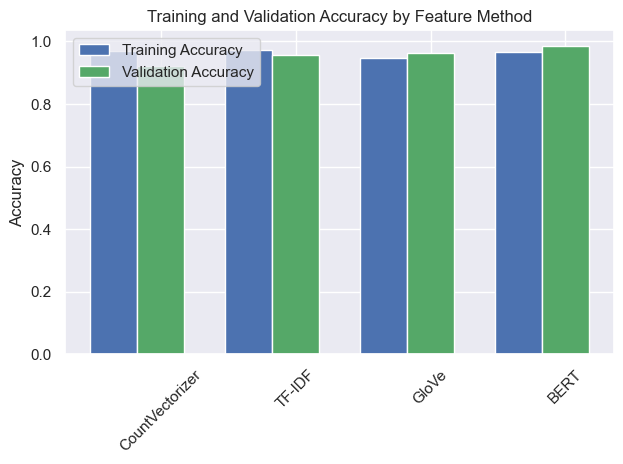

In [25]:
import matplotlib.pyplot as plt
import numpy as np

feature_methods = results_df["Feature Method"]
training_accuracies = results_df["Training Accuracy"]
validation_accuracies = results_df["Validation Accuracy"]

num_methods = len(feature_methods)
bar_width = 0.35

indices = np.arange(num_methods)
fig, ax = plt.subplots()

train_bars = ax.bar(indices, training_accuracies, bar_width, label='Training Accuracy', color='b')
val_bars = ax.bar(indices + bar_width, validation_accuracies, bar_width, label='Validation Accuracy', color='g')

x_positions = indices + bar_width
x_labels = feature_methods

ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45)
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy by Feature Method')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

question 2 below using X_tfidf since it was best perfoming in question 1

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

model = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=500, activation='relu', solver='adam')

# Define a range of learning rates to test
learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]

# Initialize lists to store results
average_train_accuracies = []
train_accuracies_std = []
average_val_accuracies = []
val_accuracies_std = []

# Perform 5-fold cross-validation for each learning rate
for learning_rate in learning_rates:
    model.learning_rate_init = learning_rate
    train_scores = cross_val_score(model, X_tfidf, y, cv=5)
    average_train_accuracies.append(train_scores.mean())
    train_accuracies_std.append(train_scores.std())

    val_scores = cross_val_score(model, X_tfidf, y, cv=5)
    average_val_accuracies.append(val_scores.mean())
    val_accuracies_std.append(val_scores.std())

# Organize the results in a table
results = {
    "Learning Rate": learning_rates,
    "Average Training Accuracy": average_train_accuracies,
    "Training Accuracy Std Dev": train_accuracies_std,
    "Average Validation Accuracy": average_val_accuracies,
    "Validation Accuracy Std Dev": val_accuracies_std
}

results_df = pd.DataFrame(results)
results_df

,Learning Rate,Average Training Accuracy,Training Accuracy Std Dev,Average Validation Accuracy,Validation Accuracy Std Dev
0,0.0001,0.9708,0.0054,0.9718,0.0107
1,0.0003,0.9756,0.0091,0.9746,0.0063
2,0.0010,0.9746,0.0070,0.9708,0.0096
3,0.0030,0.9708,0.0054,0.9774,0.0054
4,0.0100,0.9596,0.0191,0.9530,0.0170
5,0.0300,0.9445,0.0272,0.9445,0.0069
6,0.1000,0.9314,0.0300,0.9436,0.0098


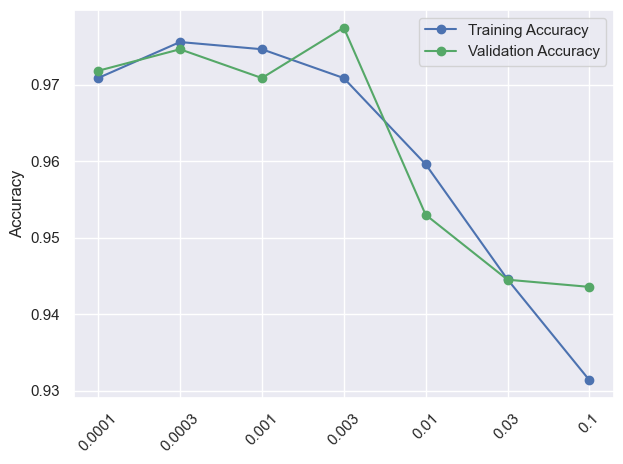

In [29]:
import matplotlib.pyplot as plt
import numpy as np

indices = np.arange(len(learning_rates))
fig, ax = plt.subplots()

ax.plot(indices, average_train_accuracies, marker='o', label='Training Accuracy', color='b')
ax.plot(indices, average_val_accuracies, marker='o', label='Validation Accuracy', color='g')
ax.set_xticks(indices)
ax.set_xticklabels(learning_rates)
ax.set_ylabel('Accuracy')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


question 2 part 2 using tfid from question 1

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

optimizers = ['sgd', 'adam', 'lbfgs']

average_train_accuracies = []
train_accuracies_std = []
average_val_accuracies = []
val_accuracies_std = []

model = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=100)

for optimizer in optimizers:
    model.solver = optimizer
    train_scores = cross_val_score(model, X_tfidf, y, cv=5)
    average_train_accuracies.append(train_scores.mean())
    train_accuracies_std.append(train_scores.std())

    val_scores = cross_val_score(model, X_tfidf, y, cv=5)
    average_val_accuracies.append(val_scores.mean())
    val_accuracies_std.append(val_scores.std())
    print(optimizer)

results = {
    "Optimizer": optimizers,
    "Average Training Accuracy": average_train_accuracies,
    "Training Accuracy Std Dev": train_accuracies_std,
    "Average Validation Accuracy": average_val_accuracies,
    "Validation Accuracy Std Dev": val_accuracies_std
}

results_df = pd.DataFrame(results)
results_df


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

sgd
adam
lbfgs


,Optimizer,Average Training Accuracy,Training Accuracy Std Dev,Average Validation Accuracy,Validation Accuracy Std Dev
0,sgd,0.2361,0.0067,0.2512,0.0178
1,adam,0.9755,0.0019,0.9746,0.0076
2,lbfgs,0.9652,0.0147,0.9596,0.0166


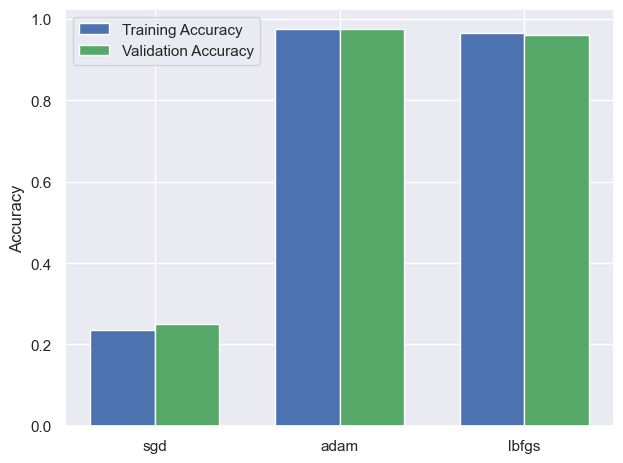

In [9]:
bar_width = 0.35

indices = range(len(optimizers))

fig, ax = plt.subplots()

ax.bar(indices, average_train_accuracies, bar_width, label='Training Accuracy', color='b')
ax.bar([i + bar_width for i in indices], average_val_accuracies, bar_width, label='Validation Accuracy', color='g')
ax.set_xticks([i + bar_width/2 for i in indices])
ax.set_xticklabels(optimizers)
ax.set_ylabel('Accuracy')

ax.legend()

plt.tight_layout()
plt.show()

trained and outputs to labels.csv

In [41]:
from sklearn.model_selection import train_test_split
import pandas as pd

test_df['Processed_Text'] = test_df['Text'].apply(get_tokens)
X_test = test_df['Processed_Text'].apply(lambda x: ' '.join(x)).tolist()

tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab)
X_train_tfidf = tfidf_vectorizer.fit_transform(X)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

mlp_classifier = MLPClassifier(learning_rate_init=0.0003, solver='adam', random_state=seed)
mlp_classifier.fit(X_train_tfidf, y)

y_pred = mlp_classifier.predict(X_test_tfidf)

test_df['Predicted_Category'] = y_pred

test_df.to_csv('labels.csv', index=False, header=False)


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
